In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [11]:
tf.keras.applications.vgg16.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
).summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, target_category=None
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions.
    # In other words, this is like the forward hook of torch.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output],
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # last_conv_layer_output: Note this is merely the output when the inputs propagate to the last conv layer.
        # i.e. this is the output of the last conv layer. and is not flattened yet
        last_conv_layer_output, y_logits = grad_model(img_array)
        print(y_logits.shape)
        # last_conv_layer_output: shape = (1, 14, 14, 512)
        # which is 512 number of filters of 14 x 14 filters.
        # print(last_conv_layer_output.shape)
        # print(y_logits[:, 386]) should be the same as what we had earlier!
        if target_category is None:
            target_category = tf.argmax(y_logits[0])
        target_category_logits = y_logits[:, target_category]
        print(target_category_logits)

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(target_category_logits, last_conv_layer_output)
    # print(grads.shape) same shape as last conv layer! (1, 14, 14, 512)

    #  do not confuse gradient of loss fn with respect to inputs
    # we are talking about gradient of y_c with respect to feature maps (not the raw image input array), note the distinction.
    # so we r checking the rate of change of y_c wrt the feature maps
    # we are checking the rate of change of elephant wrt to elephants feature maps

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # print(pooled_grads.shape) # (512,)
    # by hn
    grads_transposed = np.transpose(np.squeeze(grads, axis=0), axes=None)
    # print(grads_transposed.shape)

    for feature_map in grads_transposed:
        mean_feature_map = np.mean(feature_map)
        print(mean_feature_map)  # same as  print(pooled_grads[0])
        print(pooled_grads[0])
        break

    # one should readily understand

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[
        0
    ]  # this is just squeeze dimension from (1,14,14,512) to (14,14,512)
    print(last_conv_layer_output.shape)

    # in Python "..." means "all dimensions prior to" add new axis.
    # print(pooled_grads[..., tf.newaxis].shape) # (512, ) to (512, 1)

    print(last_conv_layer_output)
    heatmap = (
        last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    )  # same as heatmap = last_conv_layer_output @ tf.expand_dims(pooled_grads, axis=-1)

    print(heatmap.shape)  # (14, 14, 1)
    heatmap = tf.squeeze(heatmap)  # (14, 14)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1 RELU OPS
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


In [30]:
model_builder = keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions
last_conv_layer_name = "block5_conv3"
# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

In [31]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is.

# preds has a shape of (1, 1000)
preds = model.predict(img_array)
# if you print argmax along column, or simply put
# argmax of all logits in the 1000 predictions, we have 386 the elephant as index
print(
    f"preds argmax: {preds.argmax(axis=1)}\n preds value: {preds[:, preds.argmax(axis=1)]}"
)
# !!!
# Important is we did not activate softmax here, in fact, since softmax is monotonic, when pre-softmax, the logits output will tell us already which class is most probable!
# means to say even we did not make the logits in between 0 and 1, the ranking is preserved in the sense that values in logits the highest is the most probable when transformed by softmax

# decode predictions - this is a convenient function from keras
print("Predicted:", decode_predictions(preds, top=1)[0])


preds argmax: [386]
 preds value: [[23.632017]]
Predicted: [('n02504458', 'African_elephant', 23.632017)]


In [32]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

(1, 1000)
tf.Tensor([23.632017], shape=(1,), dtype=float32)
-0.00016475434
tf.Tensor(-0.00016475434, shape=(), dtype=float32)
(14, 14, 512)
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0

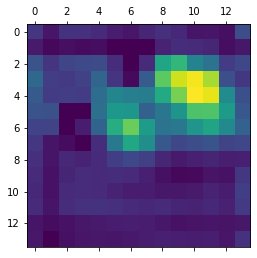

In [33]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

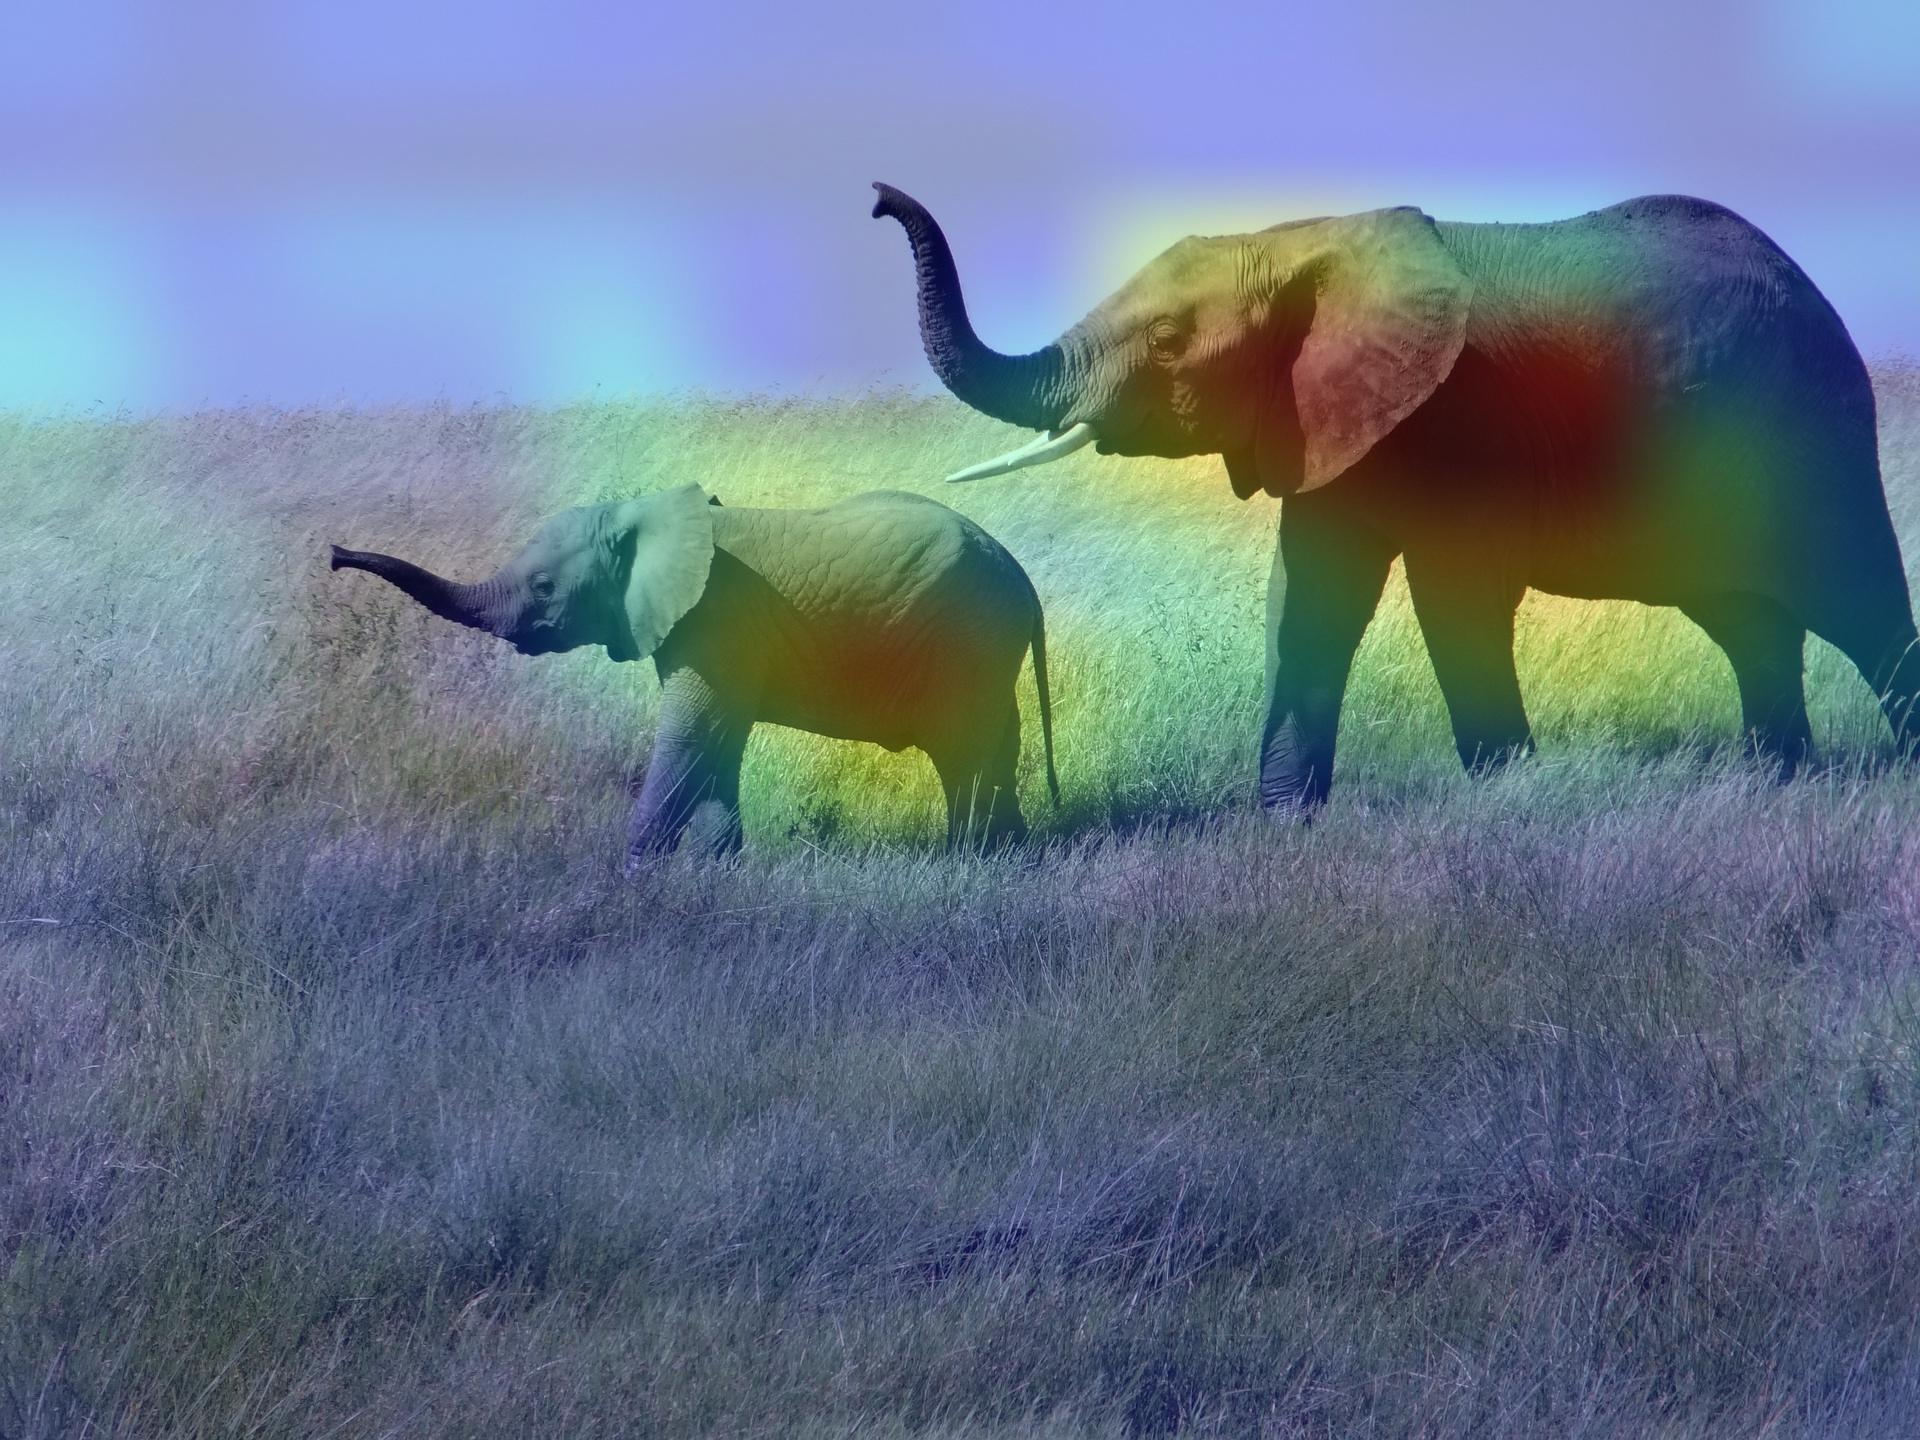

In [34]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

81920/72452 [=================================] - 0s 0us/step


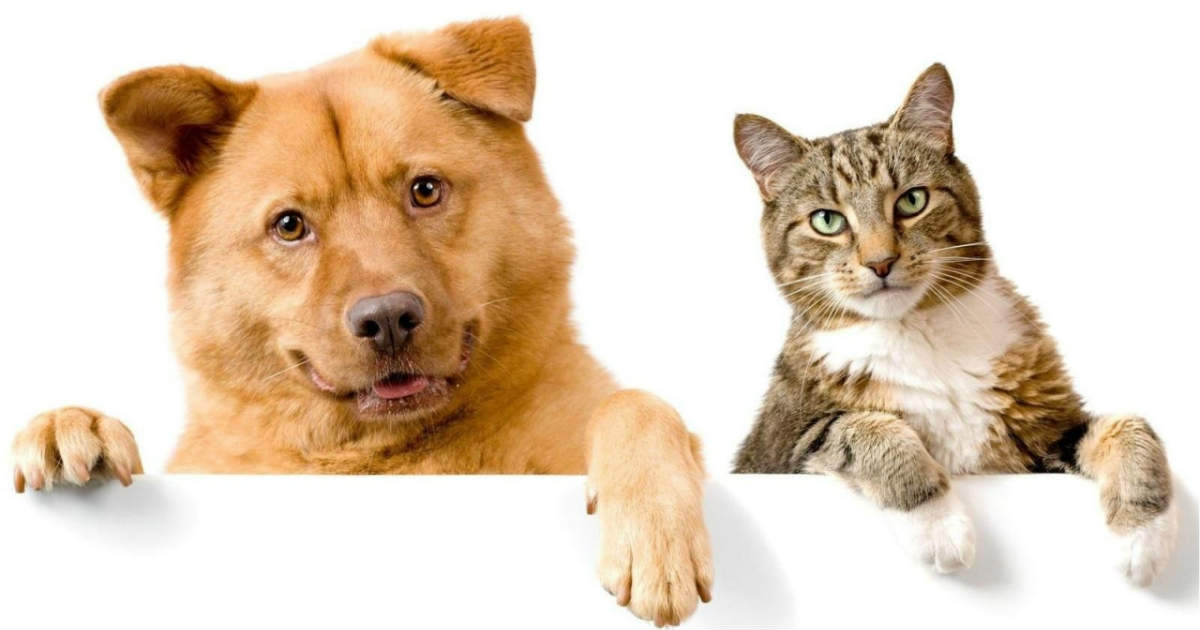

Predicted: [('n02106030', 'collie', 8.145561), ('n02110806', 'basenji', 7.812906)]


In [19]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

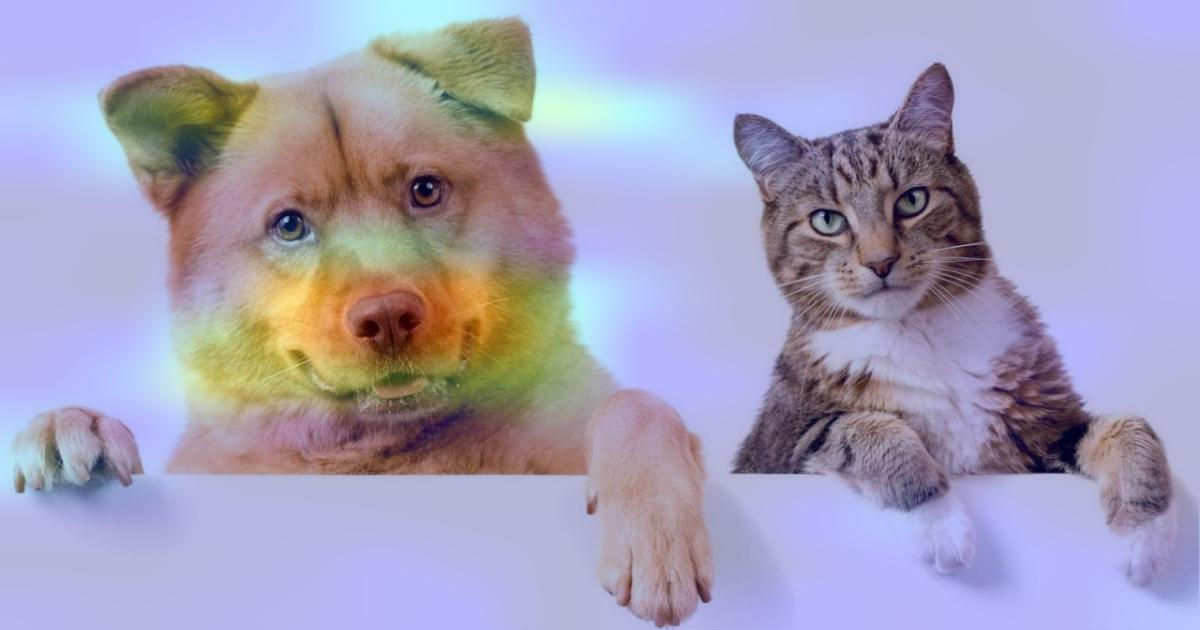

In [20]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

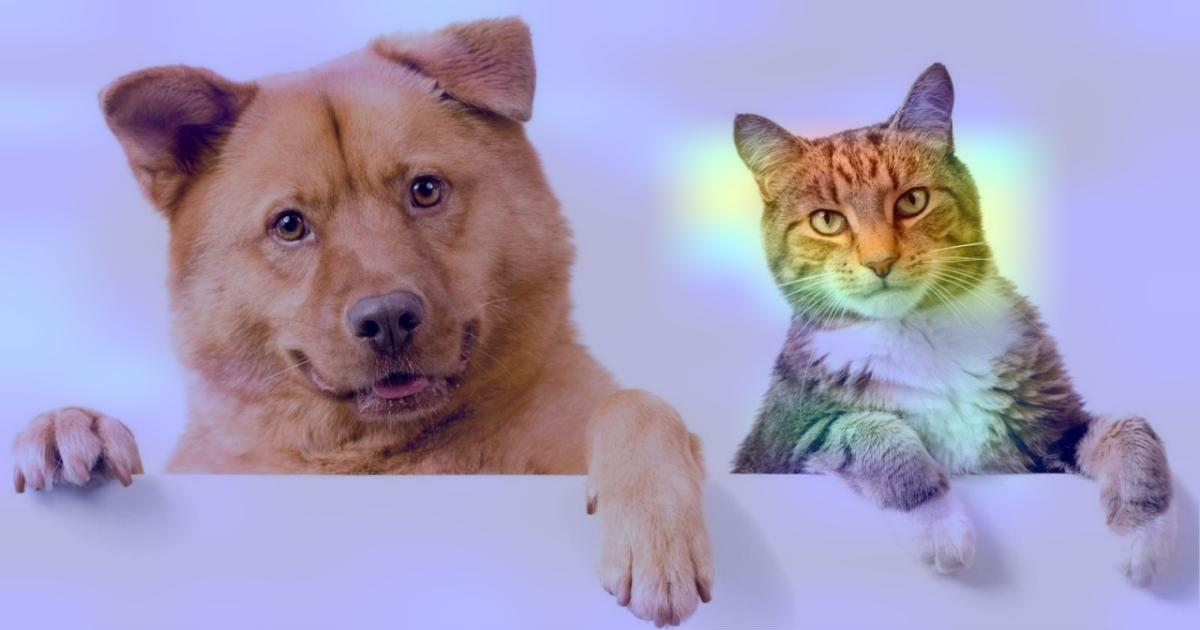

In [21]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)